In [8]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

from xgboost import XGBRegressor
from sklearn.impute import KNNImputer

In [9]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

In [10]:
df = pd.read_csv('../data/all-data.csv')
print(df.head())

   Unnamed: 0        Date  Day  Month  Year  DayOfWeek  HomeTeam       AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR      Referee    HS    AS   HST  AST   HC   AC    HF    AF   HY   AY   HR   AR  H14  A14 Attendance  Strictness  Season  Round  Hpts  Apts  HTS  ATS  HGSR  AGSR  Home_DS  Away_DS  Home_Form_Points  Away_Form_Points  Home_Goal_Diff_Form  Away_Goal_Diff_Form  Home_Win_Streak  Away_Win_Streak  Home_H2H_Win_Rate  Away_H2H_Win_Rate  HTV($m)  ATV($m)  HTPos_avg  ATPos_avg  HSPE (%)  HPE (%)  ASPE (%)  APE (%)
0           0  19/08/2000   19      8  2000          7  Charlton       Man City   4.0   0.0   H   2.0   0.0   H     R Harris  17.0   8.0  14.0  4.0  6.0  6.0  13.0  12.0  1.0  2.0  0.0  0.0    0    0     20,043   15.272727    2000      1     0     0  0.0  0.0   0.0   0.0      0.0      0.0               0.0               0.0                  0.0                  0.0                0                0                0.0                0.0      NaN      NaN        NaN        NaN   

In [11]:
def compute_head_to_head(row, matches):
    relevant_matches = matches[(
        ((matches['HomeTeam'] == row['HomeTeam']) & (matches['AwayTeam'] == row['AwayTeam'])) |
        ((matches['HomeTeam'] == row['AwayTeam']) & (matches['AwayTeam'] == row['HomeTeam']))
    )]
    
    home_wins = (
        ((relevant_matches['HomeTeam'] == row['HomeTeam']) & (relevant_matches['FTR'] == 'H')) |
        ((relevant_matches['AwayTeam'] == row['HomeTeam']) & (relevant_matches['FTR'] == 'A'))
    ).sum()
    
    away_wins = (
        ((relevant_matches['HomeTeam'] == row['AwayTeam']) & (relevant_matches['FTR'] == 'H')) |
        ((relevant_matches['AwayTeam'] == row['AwayTeam']) & (relevant_matches['FTR'] == 'A'))
    ).sum()
    
    return (home_wins - away_wins) / max(len(relevant_matches), 1)

In [12]:
def compute_directional_head_to_head(row, matches):
    relevant_matches = matches[(matches['HomeTeam'] == row['HomeTeam']) & (matches['AwayTeam'] == row['AwayTeam'])]
    home_wins = (relevant_matches['FTR'] == 'H').sum()
    away_wins = (relevant_matches['FTR'] == 'A').sum()
    return (home_wins - away_wins) / max(len(relevant_matches), 1)

In [13]:
def replace_second_h(stat):
    if stat.count('H') > 1:
        h_index = stat.find('H', stat.find('H') + 1)
        return stat[:h_index] + 'A' + stat[h_index + 1:]
    return stat.replace('H', 'A')

def compute_recent_stats(team, matches, stat, num_games=5):
    team_matches = matches[(matches['HomeTeam'] == team) | (matches['AwayTeam'] == team)].tail(num_games)
    home_stats = team_matches[team_matches['HomeTeam'] == team][stat].sum()
    away_stats = team_matches[team_matches['AwayTeam'] == team][replace_second_h(stat)].sum()
    total_stats = home_stats + away_stats
    return total_stats / num_games if len(team_matches) > 0 else np.nan

In [14]:
def compute_points_per_game(team, matches, num_games=5):
    team_matches = matches[(matches['HomeTeam'] == team) | (matches['AwayTeam'] == team)].tail(num_games)
    points = 0
    for _, match in team_matches.iterrows():
        if match['HomeTeam'] == team:
            if match['FTR'] == 'H':
                points += 3
            elif match['FTR'] == 'D':
                points += 1
        elif match['AwayTeam'] == team:
            if match['FTR'] == 'A':
                points += 3
            elif match['FTR'] == 'D':
                points += 1
    return points / num_games if len(team_matches) > 0 else np.nan

In [15]:
def compute_head_to_head_and_ppg_features(df):
    df = df.copy()

    # Head-to-Head Features
    df['GeneralHeadToHead'] = df.apply(lambda row: compute_head_to_head(row, df[:row.name]), axis=1)
    df['DirectionalHeadToHead'] = df.apply(lambda row: compute_directional_head_to_head(row, df[:row.name]), axis=1)

    # Recent Performance Metrics
    stats_to_average = ['HS', 'HST', 'HC', 'FTHG', 'HTHG', 'HF', 'HY', 'HR']
    for stat in stats_to_average:
        df[f'Home_{stat}_Avg'] = df.apply(lambda row: compute_recent_stats(row['HomeTeam'], df[:row.name], stat), axis=1)
        df[f'Away_{replace_second_h(stat)}_Avg'] = df.apply(lambda row: compute_recent_stats(row['AwayTeam'], df[:row.name], stat), axis=1)

    # Points Per Game Feature
    df['Home_PPG'] = df.apply(lambda row: compute_points_per_game(row['HomeTeam'], df[:row.name]), axis=1)
    df['Away_PPG'] = df.apply(lambda row: compute_points_per_game(row['AwayTeam'], df[:row.name]), axis=1)

    # Fill Default Values
    df.fillna({
        'GeneralHeadToHead': 0,
        'DirectionalHeadToHead': 0,
        'Home_HS_Avg': 14,
        'Away_AS_Avg': 11,
        'Home_HST_Avg': 6,
        'Away_AST_Avg': 5,
        'Home_HC_Avg': 6,
        'Away_AC_Avg': 5,
        'Home_FTHG_Avg': 2,
        'Away_FTAG_Avg': 1,
        'Home_HTHG_Avg': 1,
        'Away_HTAG_Avg': 1,
        'Home_HF_Avg': 11,
        'Away_AF_Avg': 12,
        'Home_HY_Avg': 1,
        'Away_AY_Avg': 2,
        'Home_HR_Avg': 0,
        'Away_AR_Avg': 0,
        'Home_PPG': 1.5,
        'Away_PPG': 1.2
    }, inplace=True)

    return df

In [16]:
df = compute_head_to_head_and_ppg_features(df)

In [17]:
#KNN for imputing pos_avg data

def impute_pos_avg():

    # Select features for KNN
    features = ['HS', 'AS', 'HST', 'AST', 'Hpts', 'Apts', 'Home_Form_Points', 'Away_Form_Points']
    target_columns = ["HTPos_avg", "ATPos_avg"]

    missing_mask = df[target_columns].isnull()

    for col in target_columns:
        df[f"{col}_missing"] = missing_mask[col].astype(int)

    imputation_data = df[features + target_columns].copy()

    knn_imputer = KNNImputer(n_neighbors=5)
    imputed_data = knn_imputer.fit_transform(imputation_data)

    imputed_df = pd.DataFrame(imputed_data, columns=features + target_columns)

    for col in target_columns:
        df.loc[missing_mask[col], col] = imputed_df.loc[missing_mask[col], col]

impute_pos_avg()

In [18]:
# CHECK IF THIS IS ACTUALLY USEFUL TO INCLUDE, FEELS LIKE ACCURACY DIPS SOMETIMES BECAUSE OF THIS AS THERE'S AN OBSERVED FLUCTUATION IN ACCURACY BETWEEN 0.46 AND 0.53 
# Use a combination of random forest regressor and an iterative imputer to get missing values for HSPE and ASPE

# Random Forest Regression
def random_forest_impute(df, target_col, feature_cols):
    """
    Trains a RandomForestRegressor to predict 'target_col' using 'feature_cols'.
    Fills in missing values in 'target_col' in the original df.
    """
    not_missing_mask = df[target_col].notnull()
    missing_mask = df[target_col].isnull()

    df_not_missing = df[not_missing_mask]
    df_missing = df[missing_mask]

    if df_missing.empty:
        print(f"No missing values for {target_col}. Skipping RF imputation.")
        return df

    rf = RandomForestRegressor(
        n_estimators=500,
        max_depth=20,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )

    rf.fit(df_not_missing[feature_cols], df_not_missing[target_col])
    imputed_values = rf.predict(df_missing[feature_cols])
    df.loc[missing_mask, target_col] = imputed_values

    return df

# Example feature set for random forest:
rf_features = [
    'Hpts', 'Apts', 
    'Home_Form_Points', 'Away_Form_Points',
    'Home_H2H_Win_Rate', 'Away_H2H_Win_Rate',
    'HTS', 'ATS'
]

df["HSPE_missing"] = df["HSPE (%)"].isnull().astype(int)
df["ASPE_missing"] = df["ASPE (%)"].isnull().astype(int)

df = random_forest_impute(
    df=df, 
    target_col='HSPE (%)', 
    feature_cols=rf_features
)

df = random_forest_impute(
    df=df, 
    target_col='ASPE (%)', 
    feature_cols=rf_features
)


In [19]:
# Random forest followed by iterated imputation to be able to get missing values for HPE AND APE and include them as features
df["HPE_missing"] = df["HPE (%)"].isnull().astype(int)
df["APE_missing"] = df["APE (%)"].isnull().astype(int)

rf_features_for_hpe_ape = [
    'Hpts', 'Apts',
    'Home_Form_Points', 'Away_Form_Points',
    'Home_H2H_Win_Rate', 'Away_H2H_Win_Rate',
    'HTS', 'ATS',
]

df = random_forest_impute(
    df=df,
    target_col='HPE (%)',
    feature_cols=rf_features_for_hpe_ape
)

df = random_forest_impute(
    df=df,
    target_col='APE (%)',
    feature_cols=rf_features_for_hpe_ape
)

impute_cols = (
    rf_features_for_hpe_ape + 
    ["HPE (%)", "APE (%)"]
)

impute_cols = list(dict.fromkeys(impute_cols))

iter_data = df[impute_cols].copy()

original_features = df[impute_cols].copy()  

# Initialize IterativeImputer
iter_imputer = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=500,
        max_depth=20,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ),
    max_iter=5,
    random_state=42
)

# Fit-transform
imputed_array = iter_imputer.fit_transform(iter_data)
imputed_iter_df = pd.DataFrame(imputed_array, columns=impute_cols)

df['HPE (%)']  = imputed_iter_df['HPE (%)']
df['APE (%)']  = imputed_iter_df['APE (%)']

# And revert the other features to their originals (in case the imputer changed them)
for col in set(impute_cols) - set(["HPE (%)", "APE (%)"]):
    df[col] = original_features[col]


In [20]:
df = df.drop(df.columns[0], axis=1)
df = df.drop(columns=['Date', 'FTHG', 'FTAG', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR', 'Attendance'],axis=1)
print(df.head())

   Day  Month  Year  DayOfWeek  HomeTeam       AwayTeam FTR      Referee  H14  A14  Strictness  Season  Round  Hpts  Apts  HTS  ATS  HGSR  AGSR  Home_DS  Away_DS  Home_Form_Points  Away_Form_Points  Home_Goal_Diff_Form  Away_Goal_Diff_Form  Home_Win_Streak  Away_Win_Streak  Home_H2H_Win_Rate  Away_H2H_Win_Rate  HTV($m)  ATV($m)  HTPos_avg  ATPos_avg  HSPE (%)   HPE (%)  ASPE (%)   APE (%)  GeneralHeadToHead  DirectionalHeadToHead  Home_HS_Avg  Away_AS_Avg  Home_HST_Avg  Away_AST_Avg  Home_HC_Avg  Away_AC_Avg  Home_FTHG_Avg  Away_FTAG_Avg  Home_HTHG_Avg  Away_HTAG_Avg  Home_HF_Avg  Away_AF_Avg  Home_HY_Avg  Away_AY_Avg  Home_HR_Avg  Away_AR_Avg  Home_PPG  Away_PPG  HTPos_avg_missing  ATPos_avg_missing  HSPE_missing  ASPE_missing  HPE_missing  APE_missing
0   19      8  2000          7  Charlton       Man City   H     R Harris    0    0   15.272727    2000      1     0     0  0.0  0.0   0.0   0.0      0.0      0.0               0.0               0.0                  0.0                  

In [21]:
one_hot_encoded_hometeam = pd.get_dummies(df['HomeTeam'], prefix='HomeTeam')
one_hot_encoded_awayteam = pd.get_dummies(df['AwayTeam'], prefix='AwayTeam')
one_hot_encoded_referee = pd.get_dummies(df['Referee'], prefix='Referee')
one_hot_encoded_ftr = pd.get_dummies(df['FTR'], prefix='FTR')
df = pd.concat([df, one_hot_encoded_hometeam, one_hot_encoded_awayteam, one_hot_encoded_referee, one_hot_encoded_ftr], axis=1)
df = df.drop(columns=['HomeTeam', 'AwayTeam', 'Referee', 'FTR'], axis=1)
print(df.head())

   Day  Month  Year  DayOfWeek  H14  A14  Strictness  Season  Round  Hpts  Apts  HTS  ATS  HGSR  AGSR  Home_DS  Away_DS  Home_Form_Points  Away_Form_Points  Home_Goal_Diff_Form  Away_Goal_Diff_Form  Home_Win_Streak  Away_Win_Streak  Home_H2H_Win_Rate  Away_H2H_Win_Rate  HTV($m)  ATV($m)  HTPos_avg  ATPos_avg  HSPE (%)   HPE (%)  ASPE (%)   APE (%)  GeneralHeadToHead  DirectionalHeadToHead  Home_HS_Avg  Away_AS_Avg  Home_HST_Avg  Away_AST_Avg  Home_HC_Avg  Away_AC_Avg  Home_FTHG_Avg  Away_FTAG_Avg  Home_HTHG_Avg  Away_HTAG_Avg  Home_HF_Avg  Away_AF_Avg  Home_HY_Avg  Away_AY_Avg  Home_HR_Avg  Away_AR_Avg  Home_PPG  Away_PPG  HTPos_avg_missing  ATPos_avg_missing  HSPE_missing  ASPE_missing  HPE_missing  APE_missing  HomeTeam_Arsenal  HomeTeam_Aston Villa  HomeTeam_Birmingham  HomeTeam_Blackburn  HomeTeam_Blackpool  HomeTeam_Bolton  HomeTeam_Bournemouth  HomeTeam_Bradford  HomeTeam_Brentford  HomeTeam_Brighton  HomeTeam_Burnley  HomeTeam_Cardiff  HomeTeam_Charlton  HomeTeam_Chelsea  \
0   

In [22]:
df["HTV_missing"] = df["HTV($m)"].isnull().astype(int)
df["ATV_missing"] = df["ATV($m)"].isnull().astype(int)

valuation_features = [
    "Season", "Round",
    "Hpts", "Apts",
    "Home_Form_Points", "Away_Form_Points",
    "Home_Win_Streak", "Away_Win_Streak",
    "Home_H2H_Win_Rate", "Away_H2H_Win_Rate"
]

def xgb_impute(df, target_col, feature_cols):
    not_missing_mask = df[target_col].notnull()
    missing_mask = df[target_col].isnull()

    if df[missing_mask].empty:
        return df
    
    df_not_missing = df[not_missing_mask].copy()
    df_missing = df[missing_mask].copy()

    xgb = XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )

    xgb.fit(
        df_not_missing[feature_cols],
        df_not_missing[target_col]
    )

    imputed_values = xgb.predict(df_missing[feature_cols])

    df.loc[missing_mask, target_col] = imputed_values

    return df

df = xgb_impute(df, target_col="HTV($m)", feature_cols=valuation_features)
df = xgb_impute(df, target_col="ATV($m)", feature_cols=valuation_features)



In [23]:
X = df.drop(columns=['FTR_A', 'FTR_D', 'FTR_H'])
y = df[['FTR_A', 'FTR_D', 'FTR_H']]

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3962 - loss: 1.0994 - val_accuracy: 0.4705 - val_loss: 1.0390 - learning_rate: 0.0010
Epoch 2/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4803 - loss: 1.0347 - val_accuracy: 0.4870 - val_loss: 1.0158 - learning_rate: 0.0010
Epoch 3/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4957 - loss: 1.0225 - val_accuracy: 0.4966 - val_loss: 1.0039 - learning_rate: 0.0010
Epoch 4/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5059 - loss: 1.0075 - val_accuracy: 0.4911 - val_loss: 1.0092 - learning_rate: 0.0010
Epoch 5/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5002 - loss: 0.9886 - val_accuracy: 0.4733 - val_loss: 0.9951 - learning_rate: 0.0010
Epoch 6/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5312 - loss: 0.9733 - val_accuracy: 0.4815 - val_loss: 0.9930 - learning_rate: 0.0010
Epoch 7/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5399 - loss: 0.9616 - val_a

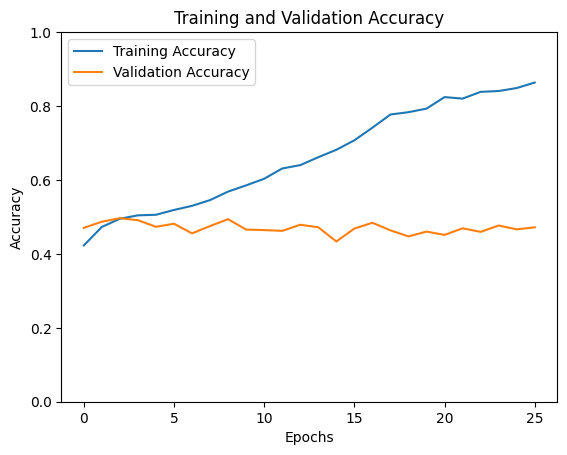

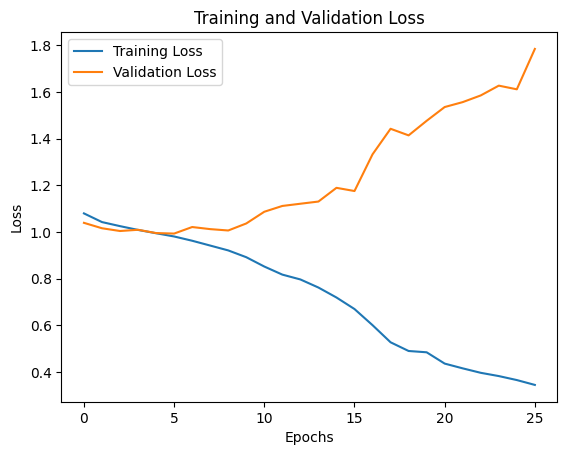

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4880 - loss: 1.0299
Test Accuracy: 0.49
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
Confusion Matrix:
[[287 130 129]
 [144 126 170]
 [167 197 474]]
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.53      0.50       546
           1       0.28      0.29      0.28       440
           2       0.61      0.57      0.59       838

    accuracy                           0.49      1824
   macro avg       0.46      0.46      0.46      1824
weighted avg       0.49      0.49      0.49      1824



In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(y.shape[1]),
    y=np.argmax(y.values, axis=1)
)
class_weights = dict(enumerate(class_weights))

model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])


model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Visualize training and validation accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()

# Visualize training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

y_pred = model.predict(X_test)
y_pred_original = np.argmax(y_pred, axis=1)
y_test_original = np.argmax(y_test.values, axis=1)

print("Confusion Matrix:")
print(confusion_matrix(y_test_original, y_pred_original))

print("Classification Report:")
print(classification_report(y_test_original, y_pred_original))